In [35]:
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO
using CSV, DataFrames
using SciMLSensitivity, OptimizationPolyalgorithms, Zygote

In [2]:
fleas(t) = 1.15 + 0.08*sin(2*pi/12*t) + 0.1*cos(2*pi/12*t)
intervention(t, theta, tau) = 1.0-1 / (1 + theta + exp(tau- t))
#fleas(t) = 1.0;

intervention (generic function with 1 method)

In [3]:
function sei(du, u, p, t)
    a1, a2, mu, muI, theta, tau = p;
    S, E, I1 = u;
    du[1] = 2317.0 - a1 * fleas(t) * intervention(t, theta, tau) * I1 * S / (S+E+I1) - mu * S
    du[2] = a1 * fleas(t) *  intervention(t, theta, tau) * S * (I1/(S+E+I1)) - a2 * E - mu * E
    du[3] = a2 * E - (muI + mu) * I1
end
    

sei (generic function with 1 method)

In [21]:
df_plague = CSV.read("/home//valentin//CaseStudiesLifeSciences//data_plague_relevant.csv", DataFrame);
tsteps = df_plague.time;
rename!(df_plague, :I1 => :total);

In [22]:
df_plague_whole = CSV.read("/home//valentin//CaseStudiesLifeSciences//data_plague_2017_madagascar.csv", DataFrame)
total = df_plague_whole.bubonic+df_plague_whole.pneumonic
time_step = 1:1:length(df_plague_whole.bubonic)
insertcols!(df_plague_whole, 6, :time=>time_step, :total=>total);

In [13]:
function loss(p)
    sol = solve(prob, Tsit5(), p = [p[1], 0.2803302, 0.00001721, 0.3271069, p[2], p[3]], saveat = df_plague.time)
    loss = sum(abs2, sol[3,:] - df_plague.total)
    return loss
end

loss (generic function with 1 method)

In [23]:
u0 = [25570895.0 , 0.0, 1.0]
tspan = (0.0,length(df_plague.time))
p = [0.37,0.2803302, 0.00001721, 0.3271069,0.11 ,8.89]
prob = ODEProblem(sei, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 65.0)
u0: 3-element Vector{Float64}:
 2.5570895e7
 0.0
 1.0

In [25]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, [0.37, 0.11, 8.89], lb =[0.0, 0.0, 0.0] ,ub =  [Inf, Inf,Inf])
result_ode = Optimization.solve(optprob, IPNewton() ,  maxiters = 10000);
print(result_ode)

┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:65
┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:171
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:65


┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:171
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:65
┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:171
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.j

┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:171
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:65
┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/ACkxp/src/concrete_solve.jl:171
┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity ~/.j

retcode: Success
u: [2.197651400466758, 0.10144181852175146, 8.148199330131895]
Final objective value:     2667.825877277313


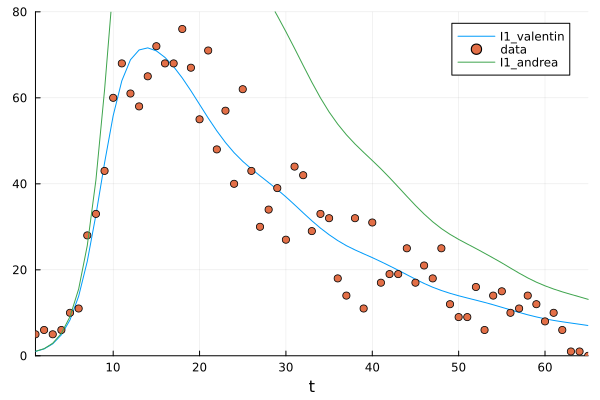

In [43]:
remade_solution = solve(prob, p = [result_ode.u[1],0.2803302, 0.00001721, 0.3271069, result_ode.u[2], result_ode.u[3]], Tsit5(),
    saveat = df_plague.time)
andrea_sol = DifferentialEquations.solve(prob, p = [2.27975248,0.2803302, 0.00001721, 0.3271069, 0.09527974, 9.17599864],Tsit5(), saveat = df_plague.time)
plot(remade_solution, idxs = (3),  ylim = (0, 80), label = "I1_valentin")
scatter!(df_plague.total, label = "data")

plot!(andrea_sol, idxs = (3), label = "I1_andrea")


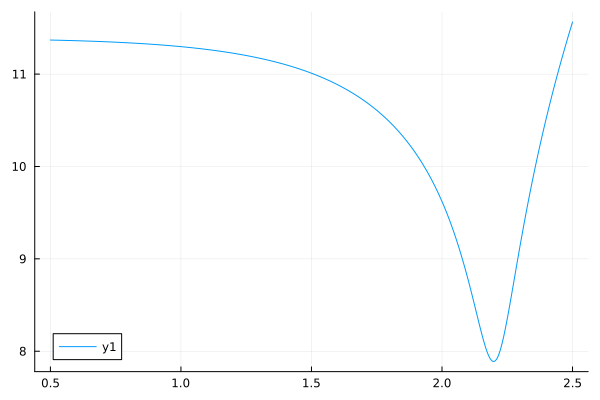

In [31]:
a = range(0.5, stop = 2.5, length = 501);
f(t) = loss([t, 0.10144181852175146, 8.148199330131895])
plot(a, log.(f.(a)))

In [26]:
plot

2675.496164164313